In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sains_df= pd.read_json('/content/drive/MyDrive/sainsburys.json')
manual_sentiment_df=pd.read_csv('/content/drive/MyDrive/manual_sentiment.csv',encoding='latin-1')

In [ ]:
sains_df.shape

(82821, 37)

#Data Cleaning and Preprocessing

In [ ]:
sains_df.columns

Index(['created_at', 'id', 'id_str', 'text', 'display_text_range', 'source',
       'truncated', 'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'quote_count', 'reply_count',
       'retweet_count', 'favorite_count', 'entities', 'favorited', 'retweeted',
       'filter_level', 'lang', 'matching_rules', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status',
       'quoted_status_permalink', 'extended_tweet', 'possibly_sensitive',
       'extended_entities', 'scopes'],
      dtype='object')

In [ ]:
#Drop irrelevant columns
sains_df.drop(columns=['display_text_range','truncated','in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name','place','geo','contributors','is_quote_status','entities','favorited', 'retweeted','filter_level','matching_rules',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status',
       'quoted_status_permalink','scopes','coordinates'],inplace=True)

In [ ]:
#Extract Only English Tweets
sains_df=sains_df[sains_df['lang']=='en'].copy()

In [ ]:
#Extract Tweet Month from Date column and Re-label to Month names
sains_df['Tweet_Month']=sains_df['created_at'].dt.month_name()
month_dist=sains_df['Tweet_Month'].value_counts()
new_order = ['January', 'February', 'March', 'April','May','June','July','August','September','October','November','December']
month_dist = month_dist.reindex(new_order, axis=0)

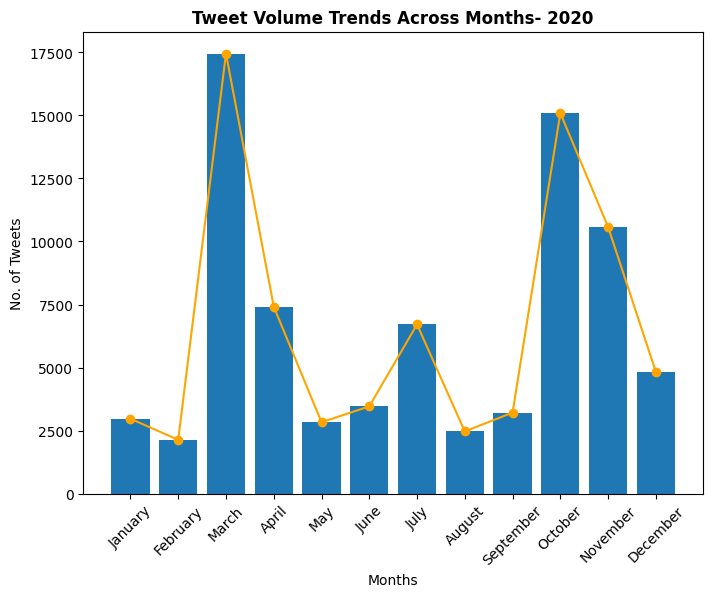

In [ ]:
#Plot Monthly Tweet Volume Trends
plt.figure(figsize=(8, 6))
plt.bar(month_dist.index,month_dist.values)
plt.plot(month_dist.index,month_dist.values, '-o', color='orange')
plt.ylabel('No. of Tweets')
plt.xlabel('Months')
plt.title("Tweet Volume Trends Across Months- 2020",fontweight='bold',size='large')
plt.xticks(rotation=45)

plt.show()

In [ ]:
#Will consider only March and October tweets as they correspond to first and second COVID-19 lockdowns
lockdown_sains_df=sains_df[(sains_df['Tweet_Month']=='March') |(sains_df['Tweet_Month']=='October') ]

In [ ]:
lockdown_sains_df=lockdown_sains_df.reset_index()

In [ ]:
#Extract Text content alone from extended tweet

lockdown_sains_df['extended_tweet']=lockdown_sains_df['extended_tweet'].str.replace("'", '"')

import re
def extract_full_text(json_str):
    match = re.search(r'"full_text":\s*"([^"]*)"', json_str)
    if match:
        return match.group(1)
    else:
        return None


lockdown_sains_df['extended_tweet'] = lockdown_sains_df['extended_tweet'].astype(str).apply(extract_full_text)

In [ ]:
#Store Tweet Content in a new column 'Final Tweet' which combines content from extended tweet and short tweets
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['extended_tweet']
short_tweets=lockdown_sains_df['extended_tweet'].isnull()
lockdown_sains_df.loc[short_tweets,'Final_Tweet']=lockdown_sains_df['text']

##Text Cleaning

In [ ]:
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].astype(str)

In [ ]:
!pip install text_preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.2 MB/s eta 0:00:00


In [ ]:
#Random 200 samples to manually label sentiment to compare performance of different sentiment models

#sample_df_sentiment=lockdown_sains_df.sample(n=200,random_state=42)
#sample_df_sentiment.to_csv("manual_sentiment.csv",index=False)

In [ ]:
import re
lockdown_sains_df['Final_Tweet']=[re.sub(r'@\w+','', x) for x in lockdown_sains_df['Final_Tweet']]

In [ ]:
import nltk
import html
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import wordnet

from nltk.tokenize import word_tokenize

from nltk.stem import WordNetLemmatizer
from nltk import ngrams

from wordcloud import WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

stopwords = set(STOPWORDS)
custom_stopwords = ['twitter', 'supermarkets','sainsbury','tweets','tweet', 'retweet','sainsburys']
stopwords.update(custom_stopwords)

from text_preprocessing import preprocess_text
from text_preprocessing import to_lower, remove_email, remove_url, remove_punctuation

preprocess_functions = [to_lower, remove_email, remove_url, remove_punctuation]

def clean_text(text):

    #Clean HTML
    text=html.unescape(text)

    #Remove Special Characters
    text = re.sub(r'\d+','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Tokenization
    tokens = word_tokenize(text)

    #Remove Stopwords
    f_tokens = [token for token in tokens if token not in stopwords]

    #Lemmatization
    lemmatizer = WordNetLemmatizer()
    l_tokens= [lemmatizer.lemmatize(token,pos=wordnet.VERB) for token in f_tokens]


    final_text=' '.join(l_tokens)

    if not final_text.strip():
      return text
    else:
        return final_text


    return final_text


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
#Cleaning
for f in preprocess_functions:
  lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].apply(f)
  manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].apply(f)


#Main DF

lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].apply(clean_text)
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].str.replace('sainsburys','')
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].str.replace('rt','')
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].str.replace('amp','and')
lockdown_sains_df['Final_Tweet']=lockdown_sains_df['Final_Tweet'].str.strip()


#Manual Sentiment DF
manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].apply(clean_text)
manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].str.replace('sainsburys','')
manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].str.replace('rt','')
manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].str.replace('amp','and')
manual_sentiment_df['Final_Tweet']=manual_sentiment_df['Final_Tweet'].str.strip()


##VADER Sentiment Analysis


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
analyzer = SentimentIntensityAnalyzer()

def get_VADER_sentiment(text):

    compound_score = analyzer.polarity_scores(text)['compound']
    return 'Positive' if compound_score >= 0.05 else 'Negative' if compound_score <= -0.05 else 'Neutral'


manual_sentiment_df['predict_VADER_sentiment']=manual_sentiment_df['Final_Tweet'].apply(get_VADER_sentiment)


In [ ]:
manual_sentiment_df[['Final_Tweet','predict_VADER_sentiment','Manual_Sentiment']]

,Final_Tweet,predict_VADER_sentiment,Manual_Sentiment
0,langers lads third world probably get things f...,Neutral,Neutral
1,piersmorgan tesco waitrose asda rid trolleys,Neutral,Positive
2,ikeijeh wont tolerate racism will tolerate pay...,Positive,Negative
3,johnwhitbypboro bye miss already,Negative,Positive
4,bold proud difference online assistant see,Positive,Positive
...,...,...,...
195,realblackirish gon na love,Positive,Positive
196,isnt store anymore scottish dog shobread onlin...,Neutral,Negative
197,well do,Positive,Positive
198,hmglondonse go share data shield vulnerable us...,Positive,Neutral


In [ ]:
#Accuracy
accuracy = (manual_sentiment_df['predict_VADER_sentiment'] == manual_sentiment_df['Manual_Sentiment']).mean()
print("VADER Prediction Accuracy:", accuracy*100,"%")

VADER Prediction Accuracy: 53.5 %


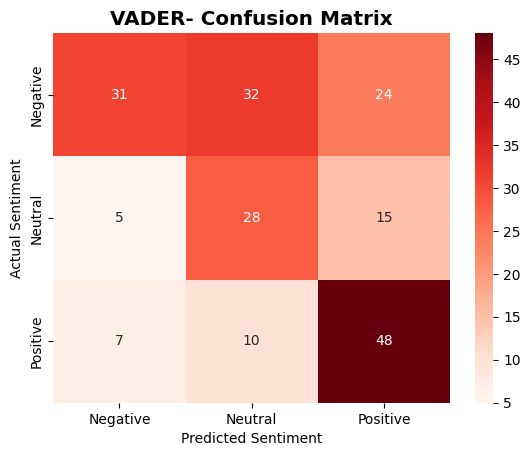

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(manual_sentiment_df['Manual_Sentiment'], manual_sentiment_df['predict_VADER_sentiment'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('VADER- Confusion Matrix',fontweight='bold',size='x-large')
plt.show()

##Roberta Sentiment

In [ ]:
#Roberta-Sentiment
!pip install transformers
!pip install scipy


import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = RobertaForSequenceClassification.from_pretrained(roberta)
tokenizer = RobertaTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from scipy.special import softmax

roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = RobertaForSequenceClassification.from_pretrained(roberta)
tokenizer = RobertaTokenizer.from_pretrained(roberta)

labels = ['Negative', 'Neutral', 'Positive']

def get_roberta_sentiment(text):
  encoded_tweets = tokenizer(text, padding=True, truncation=True, return_tensors='pt')

  with torch.no_grad():
    output = model(**encoded_tweets)

  softmax = torch.nn.functional.softmax(output.logits, dim=1)


  max_index = torch.argmax(softmax, dim=1).item()

  sentiment = labels[max_index]

  return sentiment


In [ ]:
manual_sentiment_df['roberta_predict_sentiment']=manual_sentiment_df['Final_Tweet'].apply(get_roberta_sentiment)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
manual_sentiment_df[['Final_Tweet','roberta_predict_sentiment','Manual_Sentiment']]

,Final_Tweet,roberta_predict_sentiment,Manual_Sentiment
0,langers lads third world probably get things f...,Neutral,Neutral
1,piersmorgan tesco waitrose asda rid trolleys,Neutral,Positive
2,ikeijeh wont tolerate racism will tolerate pay...,Negative,Negative
3,johnwhitbypboro bye miss already,Neutral,Positive
4,bold proud difference online assistant see,Positive,Positive
...,...,...,...
195,realblackirish gon na love,Neutral,Positive
196,isnt store anymore scottish dog shobread onlin...,Neutral,Negative
197,well do,Neutral,Positive
198,hmglondonse go share data shield vulnerable us...,Neutral,Neutral


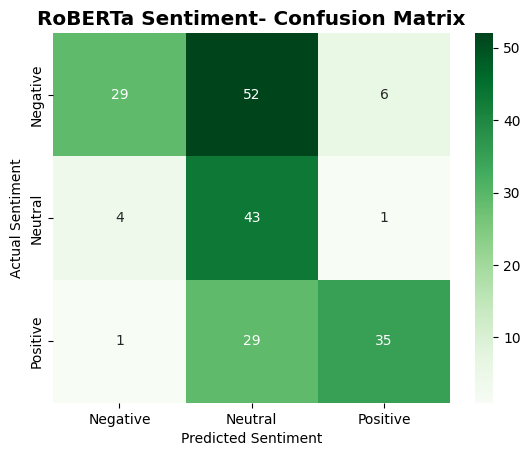

In [ ]:
cm2 = confusion_matrix(manual_sentiment_df['Manual_Sentiment'], manual_sentiment_df['roberta_predict_sentiment'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('RoBERTa Sentiment- Confusion Matrix',fontweight='bold',size='x-large')
plt.show()

In [ ]:
#Accuracy
accuracy = (manual_sentiment_df['roberta_predict_sentiment'] == manual_sentiment_df['Manual_Sentiment']).mean()
print("Roberta Prediction Accuracy:", accuracy*100,"%")

Roberta Prediction Accuracy: 53.5 %


##TextBlob Sentiment Analysis

In [ ]:
from textblob import TextBlob

def get_blob_sentiment(text):
  blob = TextBlob(text)
  sentiment_class = 'Positive' if blob.sentiment.polarity > 0 else 'Negative' if blob.sentiment.polarity < 0 else 'Neutral'
  return sentiment_class

In [ ]:
manual_sentiment_df['Blob_predict_sentiment']=manual_sentiment_df['Final_Tweet'].apply(get_blob_sentiment)

In [ ]:
manual_sentiment_df[['Final_Tweet','Blob_predict_sentiment','Manual_Sentiment']]

,Final_Tweet,Blob_predict_sentiment,Manual_Sentiment
0,langers lads third world probably get things f...,Neutral,Neutral
1,piersmorgan tesco waitrose asda rid trolleys,Neutral,Positive
2,ikeijeh wont tolerate racism will tolerate pay...,Negative,Negative
3,johnwhitbypboro bye miss already,Neutral,Positive
4,bold proud difference online assistant see,Positive,Positive
...,...,...,...
195,realblackirish gon na love,Positive,Positive
196,isnt store anymore scottish dog shobread onlin...,Neutral,Negative
197,well do,Neutral,Positive
198,hmglondonse go share data shield vulnerable us...,Negative,Neutral


In [ ]:
accuracy = (manual_sentiment_df['Blob_predict_sentiment'] == manual_sentiment_df['Manual_Sentiment']).mean()
print("TextBlob Prediction Accuracy:", accuracy*100,"%")

TextBlob Prediction Accuracy: 47.0 %


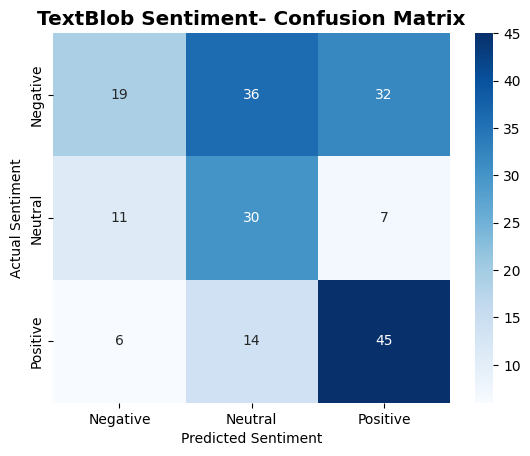

In [ ]:
cm3 = confusion_matrix(manual_sentiment_df['Manual_Sentiment'], manual_sentiment_df['Blob_predict_sentiment'])
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted Sentiment')
plt.ylabel('Actual Sentiment')
plt.title('TextBlob Sentiment- Confusion Matrix',fontweight='bold',size='x-large')
plt.show()

In [ ]:
manual_sentiment_df.columns

Index(['index', 'created_at', 'id', 'id_str', 'text', 'source', 'user',
       'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'lang',
       'retweeted_status', 'extended_tweet', 'possibly_sensitive',
       'extended_entities', 'Tweet_Month', 'Final_Tweet', 'Manual_Sentiment',
       'predict_VADER_sentiment', 'roberta_predict_sentiment',
       'Blob_predict_sentiment'],
      dtype='object')

##Word Clouds

## After companring Accuracies of 3 senitment models, VADER is selected and applied to the entire dataset

In [ ]:
lockdown_sains_df['VADER_Sentiment']=lockdown_sains_df['Final_Tweet'].apply(get_VADER_sentiment)

<ipython-input-49-c079740dd8e9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lockdown_sains_df['VADER_Sentiment'].value_counts().index,y=lockdown_sains_df['VADER_Sentiment'].value_counts().values,width=0.5, palette=palette,edgecolor='black')
<ipython-input-49-c079740dd8e9>:3: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.barplot(x=lockdown_sains_df['VADER_Sentiment'].value_counts().index,y=lockdown_sains_df['VADER_Sentiment'].value_counts().values,width=0.5, palette=palette,edgecolor='black')


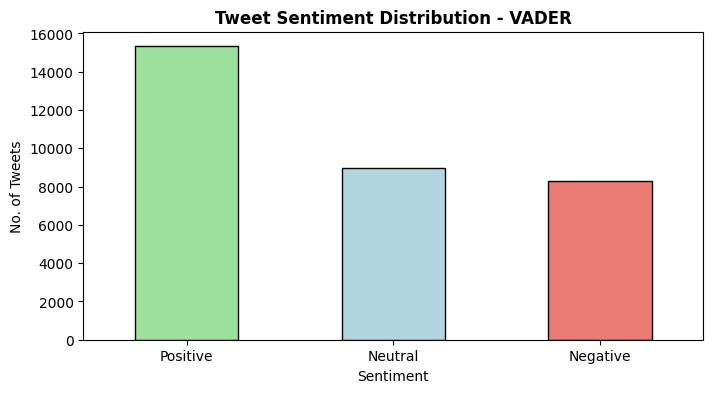

In [ ]:
plt.figure(figsize=(8,4))
palette = ["lightgreen", "#abd9e9", "#ff6961", "#313695", "#e0f3f8", "#abd9e9", "#d73027", "#a50026"]
sns.barplot(x=lockdown_sains_df['VADER_Sentiment'].value_counts().index,y=lockdown_sains_df['VADER_Sentiment'].value_counts().values,width=0.5, palette=palette,edgecolor='black')
plt.xlabel('Sentiment')
plt.ylabel('No. of Tweets')
plt.title("Tweet Sentiment Distribution - VADER", fontweight='bold',size='large')
plt.show()

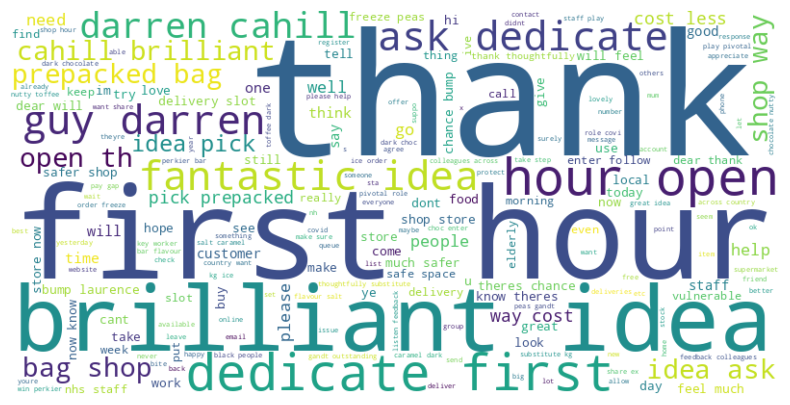

In [ ]:
#Word Clouds
def generate_wordcloud(text,c):
    wordcloud = WordCloud(width=800, height=400, background_color=c).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

positive_tweets = ' '.join(lockdown_sains_df[lockdown_sains_df['VADER_Sentiment'] == 'Positive']['Final_Tweet'])
negative_tweets = ' '.join(lockdown_sains_df[lockdown_sains_df['VADER_Sentiment'] == 'Negative']['Final_Tweet'])

generate_wordcloud(positive_tweets,'white')


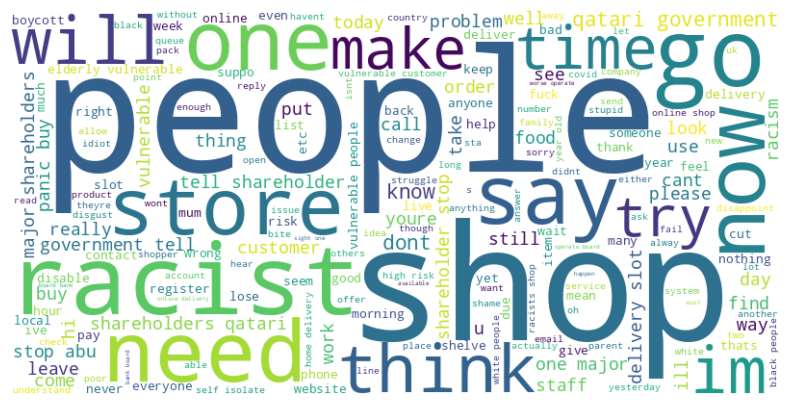

In [ ]:
generate_wordcloud(negative_tweets,'black')

## Sentiment Change Over time in the considered 2 months


In [ ]:
lockdown_sains_df.columns

Index(['index', 'created_at', 'id', 'id_str', 'text', 'source', 'user',
       'quote_count', 'reply_count', 'retweet_count', 'favorite_count', 'lang',
       'retweeted_status', 'extended_tweet', 'possibly_sensitive',
       'extended_entities', 'Tweet_Month', 'Final_Tweet', 'VADER_Sentiment'],
      dtype='object')

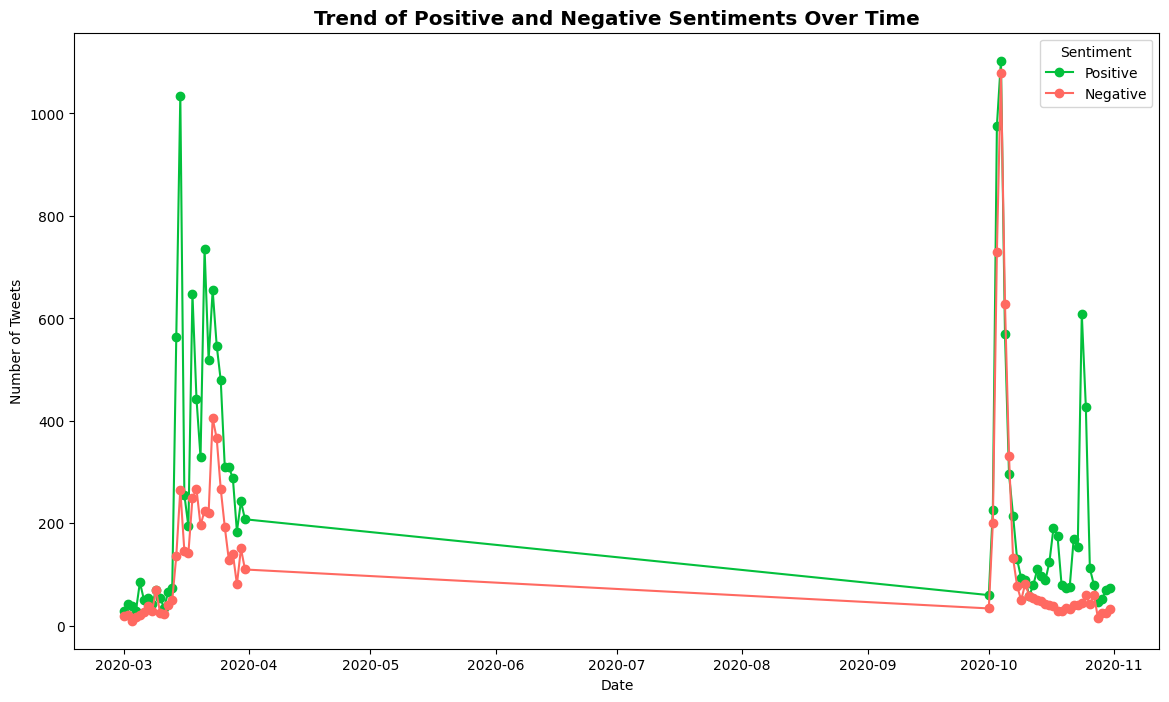

In [ ]:
#Grouping Tweet Senitments by Create Date

sentiment_counts = lockdown_sains_df.groupby([lockdown_sains_df['created_at'].dt.date, 'VADER_Sentiment']).size().unstack(fill_value=0)

plt.figure(figsize=(14,8))

plt.plot(sentiment_counts.index, sentiment_counts['Positive'], marker='o', color='#03c03c', label='Positive')
plt.plot(sentiment_counts.index, sentiment_counts['Negative'], marker='o', color='#FF6961', label='Negative')

plt.title('Trend of Positive and Negative Sentiments Over Time',fontweight='bold',size='x-large')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')

plt.legend(title='Sentiment')
plt.show()

# Topic Modelling

## BERT Topic

In [ ]:
#Data for topic modelling
topic_model_df=lockdown_sains_df.copy()

"#Do only basic cleaning for topic modelling\n\ndef repl_spl(text):\n  text = re.sub(r'\\d+', '', text)\n  text = re.sub(r'[^a-zA-Z\\s]', '', text)\n  return text\n\n\ntopic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].apply(repl_spl)\n\nfor f in preprocess_functions:\n  topic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].apply(f)\n\n#topic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].str.replace('sainsburys','')\n#topic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].str.replace('rt','')\ntopic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].str.replace('amp','and')\ntopic_model_df['Final_Tweet']=topic_model_df['Final_Tweet'].str.strip()\n"

In [ ]:
#Use only original tweets for topic modelling
topic_model_df=topic_model_df[topic_model_df['retweeted_status'].isnull()]

In [ ]:
topic_model_df.shape

(21772, 19)

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 15.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 20.0 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (7

In [ ]:
np.random.seed(42)

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired,PartOfSpeech, MaximalMarginalRelevance

main_representation_model = KeyBERTInspired()


topic_model = BERTopic(representation_model = main_representation_model)

topics, probs = topic_model.fit_transform(topic_model_df['Final_Tweet'])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
 topic_model.get_topic_info().head(16)

0                     -1_disable_customers_cant_service
1                         0_call_telephone_dial_contact
2                         1_panic_buy_stock_panicbuying
3      2_register_registration_registrations_vulnerable
4                          3_racist_racism_racists_race
5                                        4_my_no_me_its
6                          5_shop_shoppers_custom_bosch
7                   6_nhsworkers_keyworkers_workers_nhs
8                          7_racists_shop_racist_racism
9     8_elderly_elderlyhour_elderlyfolk_customerscar...
10    9_segregation_segregationnnwhat_segregationist...
11            10_space_spacesnnmaybe_racism_segregation
12           11_mask_maskless_maskingnnwhy_maskneedless
13             12_tesco_tescos_tescomorrisonsasda_tescs
14                      13_blm_protest_racist_activists
15                   14_arrive_delivery_arrival_deliver
Name: Name, dtype: object

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart(top_n_topics = 16, n_words = 10)